In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests

In [5]:
# from ducktales.feedzai_experiments.exp_results_analysis import fetch_all_decisions, grp_names_disp_name
import src.utils as u

# from ducktales.feedzai_experiments.analysis_functions import (
#     get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors
# )

In [6]:
dir(u)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'general',
 'project_constants']

In [3]:
cred_file = '../../conf/local/credentials.yaml'
engine = get_db_con(cred_file, database='feedzai_experiment')

In [5]:
def plot_metrics_feedzai_style(metrics_dict, title='', confidence=0.9, legend=True):
    groups = list(metrics_dict.keys())
    x_pos = np.arange(len(groups))
    interval = stats.norm.ppf(1-(1-confidence)/2)
    means = [x['mean'] for _, x in metrics_dict.items()]
    errors = [x['se'] * interval for _, x in metrics_dict.items()]
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 4))
    gs = fig.add_gridspec(5, 5)
    ax1 = fig.add_subplot(gs[:4, :])
    
    if legend:
        ax2 = fig.add_subplot(gs[-1:, 2:4])

    for j, grp in enumerate(pdr.keys()):
        a, caps, b = ax1.errorbar(
            means[j], (j), xerr=errors[j], ls='',
            elinewidth=2, capsize=10, color=colors[j]
        )

        ax1.scatter(means[j], (j), color=colors[j], marker='o')

        for cap in caps:
                cap.set_markeredgewidth(2)

        ax1.set_title(title, fontsize=11)
        ax1.yaxis.grid(False)
        ax1.xaxis.grid()

        ax1.set_yticks([])
        ax1.set_ylim(len(groups),-1)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax1.spines[spine].set_visible(False)

    if legend:
        color_part = []
        for i in range(len(pdr.keys())):
            color_part.append(Line2D([0], [0], color=colors[i], linewidth=2))
            color_legend = color_part, pdr.keys()

        metric_leg = ax2.axes.axes.legend(
            *color_legend,
            loc= 'upper center',
            ncol= len(groups),
            borderaxespad  = 0.,
            prop={'size':11},
            frameon=False,
        )

        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax2.spines[spine].set_visible(False)

In [6]:
def plot_metrics(metrics, title='', tick_order=['Control-A', 'Control-B', 'TreeSHAP', 'TreeInterpreter', 'LIME'], confidence=0.9):
    """ Dollars made, per second"""
    # n = x
    # h = se * stats.t.ppf((1 + confidence) / 2., n-1)
#     fig, ax = plt.subplots(dpi=200)
    fig, ax = plt.subplots()
    ax.barh(
        np.arange(4, -1, -1), 
        [x['mean'] for _, x in metrics.iterrows()], 
        xerr=[x['se'] * stats.norm.ppf(1 - (1 - confidence) / 2) for _, x in metrics.iterrows()], #CI
        align='center', 
        alpha=0.7,  
        capsize=5,
        color=colors
    )
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(tick_order[::-1])
    ax.set_title(title)
    sns.despine()
    ax.spines['left'].set_visible(False)

In [4]:
def plot_metrics2(metrics, plot_order, colors, title='', confidence=0.9, legend=True, xlim=None):
    interval = stats.norm.ppf(1-(1-confidence)/2)
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 3), dpi=200)
    gs = fig.add_gridspec(5, 5)
    ax1 = fig.add_subplot(gs[:4, :])
        
    for i, group in enumerate(plot_order):
        msk = metrics['group'] == group
        row = metrics[msk].iloc[0, :]
        a, caps, b = ax1.errorbar(
            row['mean'], (i), xerr=row['se'] * interval, ls='',
            elinewidth=2, capsize=5, color=colors[i]
        )
        
        ax1.scatter(row['mean'], (i), color=colors[i], marker='o')
        for cap in caps:
            cap.set_markeredgewidth(2)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax1.spines[spine].set_visible(False)
        ax1.set_yticks([])
    
    ax1.xaxis.grid()
    ax1.set_title(title)
    if xlim is not None:
        ax1.set_xlim(xlim)
        
    if legend:
        ax2 = fig.add_subplot(gs[-1:, 2:4])
        color_part = []
        for i in range(len(metrics)):
            color_part.append(Line2D([0], [0], color=colors[i], linewidth=2))
            color_legend = color_part, plot_order

        metric_leg = ax2.axes.axes.legend(
            *color_legend,
            loc= 'upper center',
            ncol= len(metrics) - 2,
            borderaxespad  = 0.,
            prop={'size':11},
            frameon=False,
        )

        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax2.spines[spine].set_visible(False)

In [5]:
params={
    'fn': -1, 
    'p_loss_trx': 0.3, # prob of losing this transaction
    'cust_worth': 0, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.3, # probablity of losing the customer due to the rejection
    'p_return_cust': 0.2, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

#### Fetch decisions

In [7]:
all_decisions = get_all_decisions(engine, schemas, users, groups)

In [8]:
all_decisions['group'].unique()

array(['Control-B', 'Irrelevant', 'Control-A', 'Random', 'LIME',
       'TreeInt', 'TreeSHAP'], dtype=object)

In [11]:
suspicious_msk = all_decisions['decision'] == 'suspicious'

### Adjusting the transaction values

There are a few transactions (mainly in the control arms) that are very high valued compared to the rest. These can skew the metrics when we incoroporate the transaction values. So, we are capping the transaction values at $2000.  

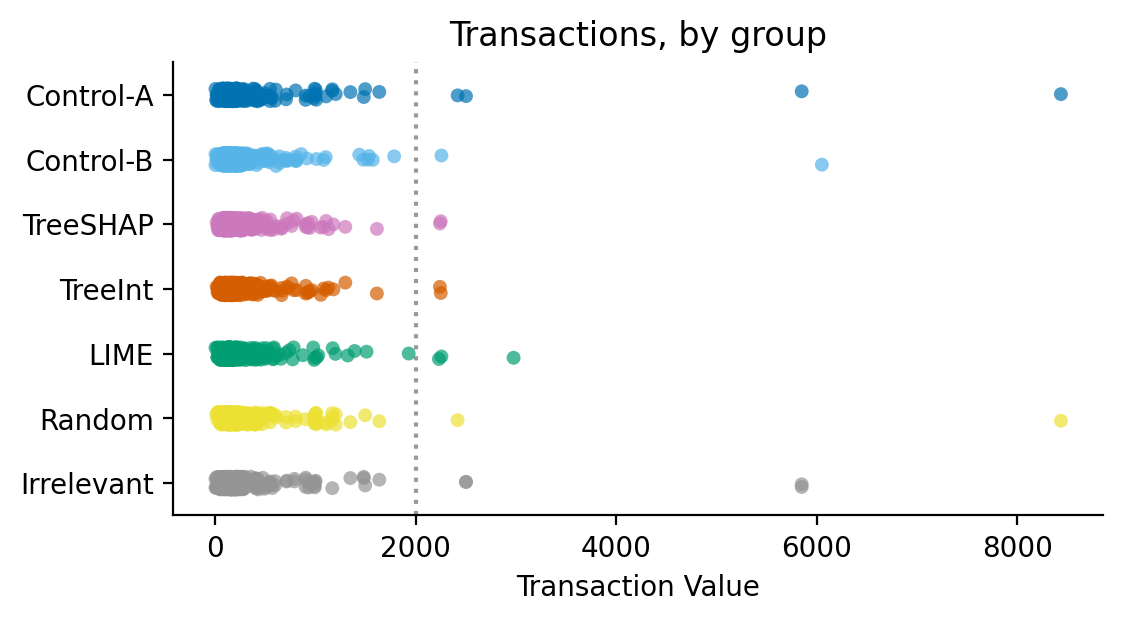

In [11]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=200)
sns.stripplot(
    x="trx_amnt", y="group", 
    data=all_decisions, alpha=0.7, 
    palette=colors, order=group_order)
plt.axvline(x=2000, color='k', linestyle=':', alpha=0.4)
sns.despine()
t = plt.title('Transactions, by group')
axes.set_xlabel('Transaction Value')
t = axes.set_ylabel('')

In [12]:
msk = all_decisions['trx_amnt'] > 2000
all_decisions.loc[msk, 'trx_amnt'] = 2000

#### Dollars made per Second

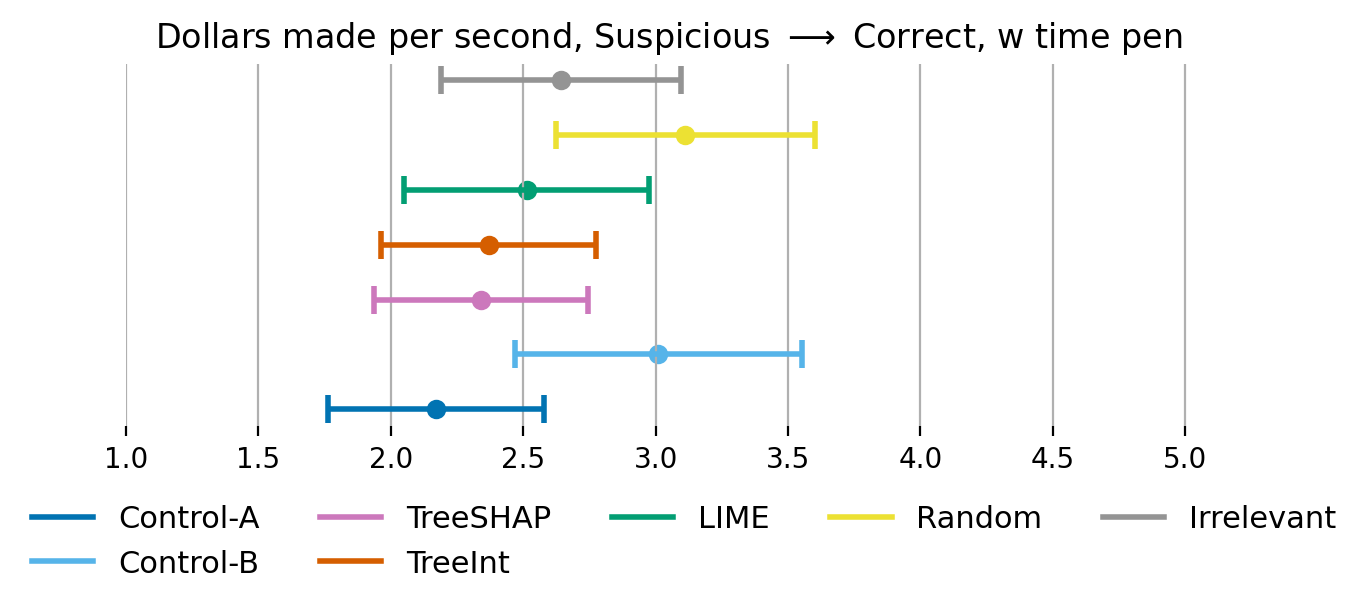

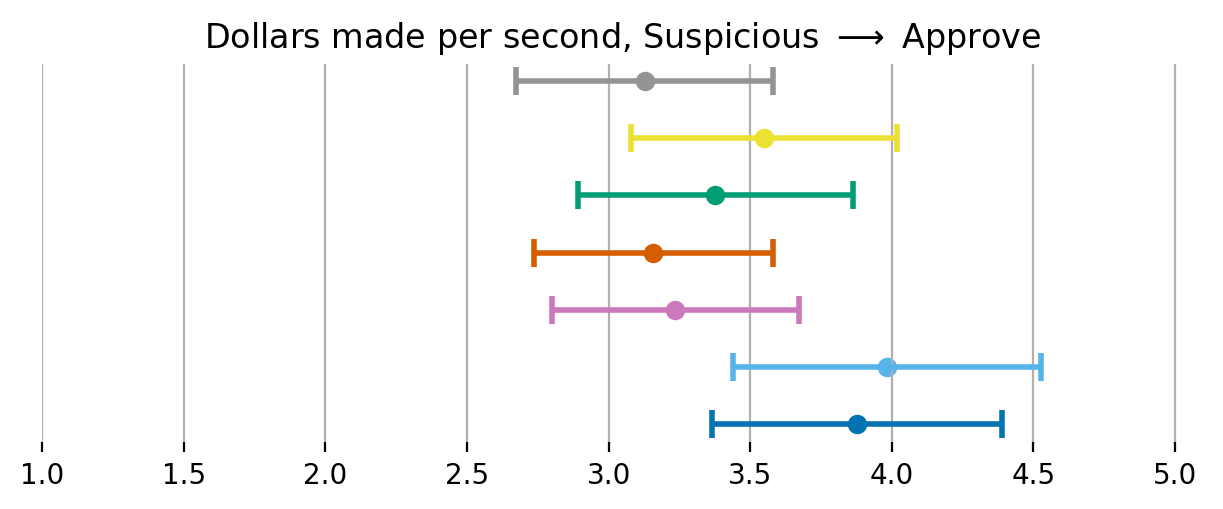

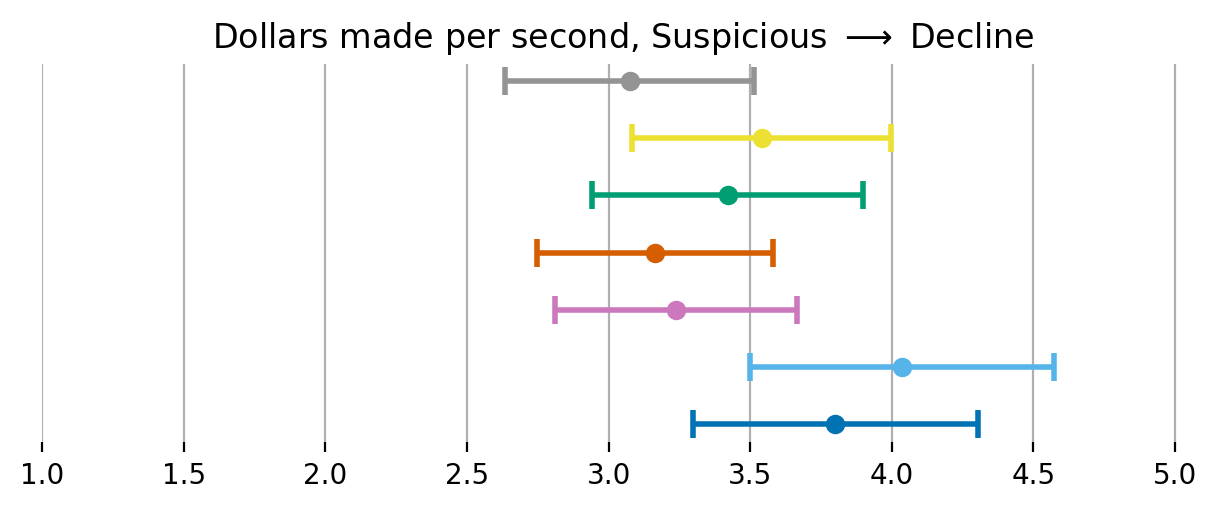

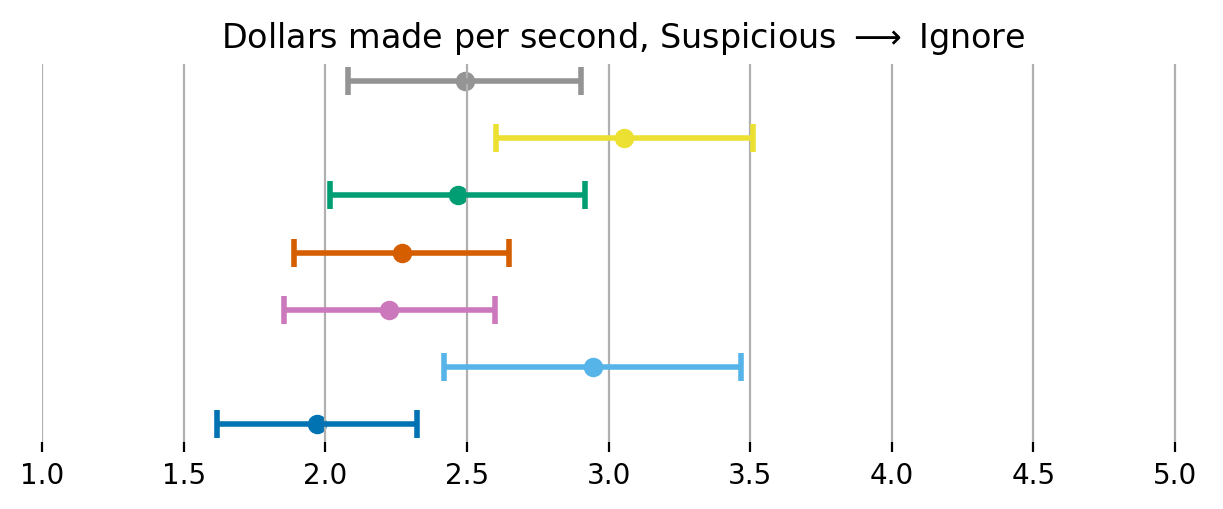

In [31]:
df = dps(all_decisions, params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, 
              title='Dollars made per second, Suspicious $\longrightarrow$ Correct, w time pen', 
              xlim=[1, 5.1], legend=True
             )

df = dps(all_decisions, params, 'approve', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Approve', xlim=[1, 5.1], legend=False)

df = dps(all_decisions, params, 'decline', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Decline', xlim=[1, 5.1], legend=False)

df = dps(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Ignore', xlim=[1, 5.1], legend=False)

#### Average Decision Time

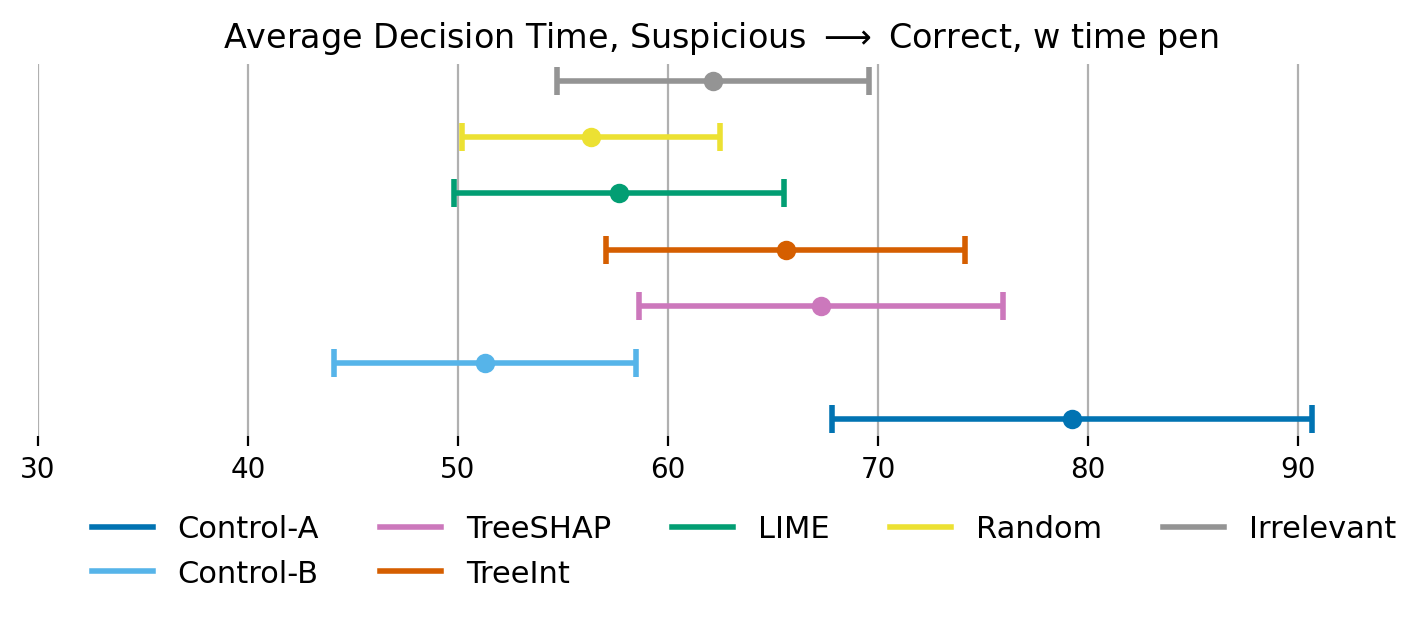

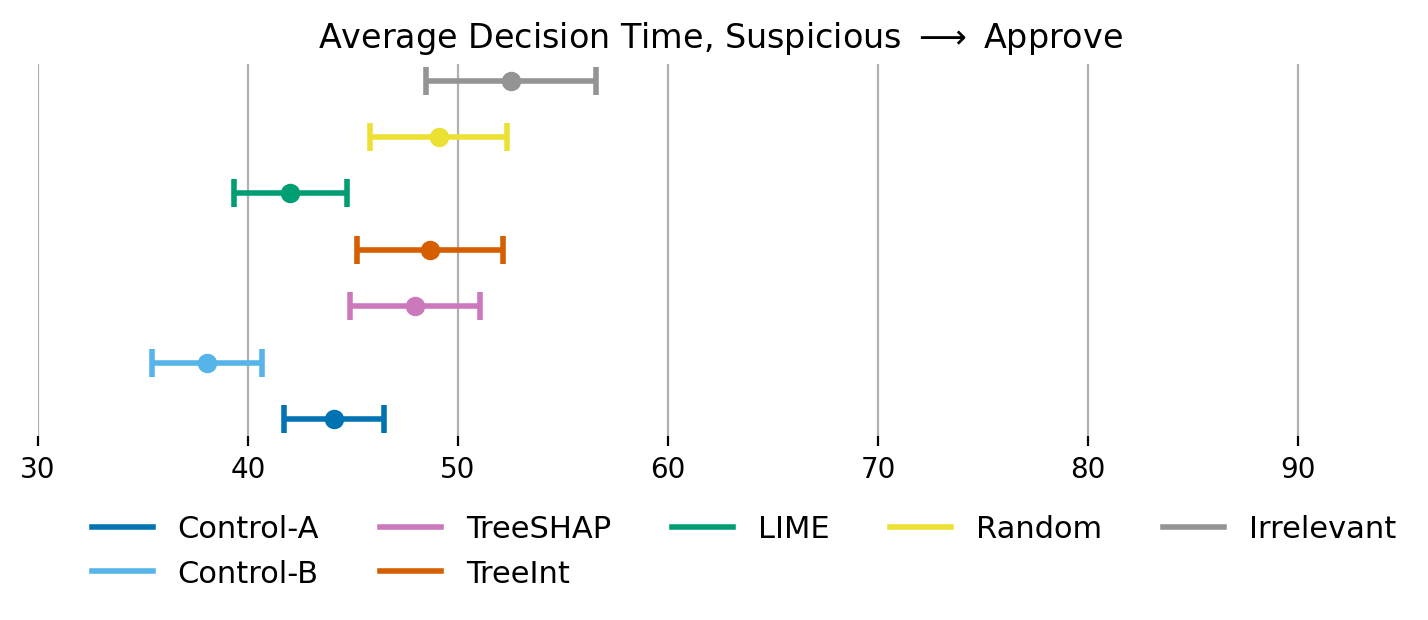

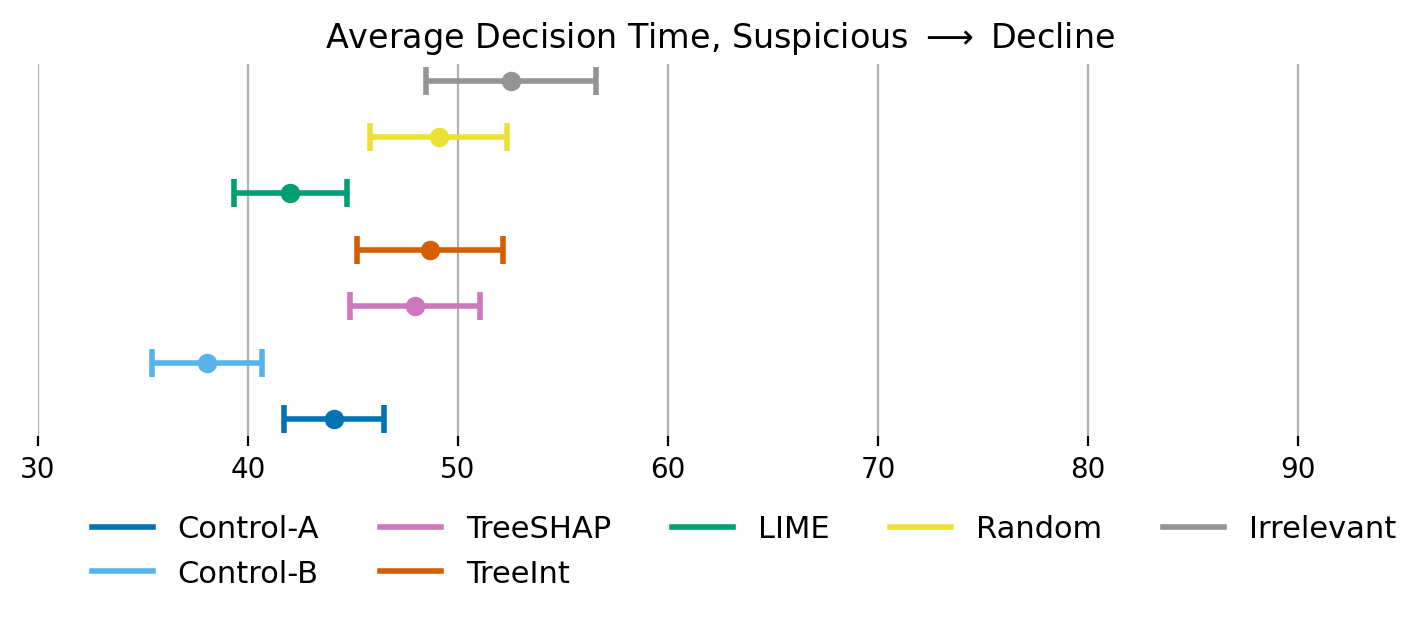

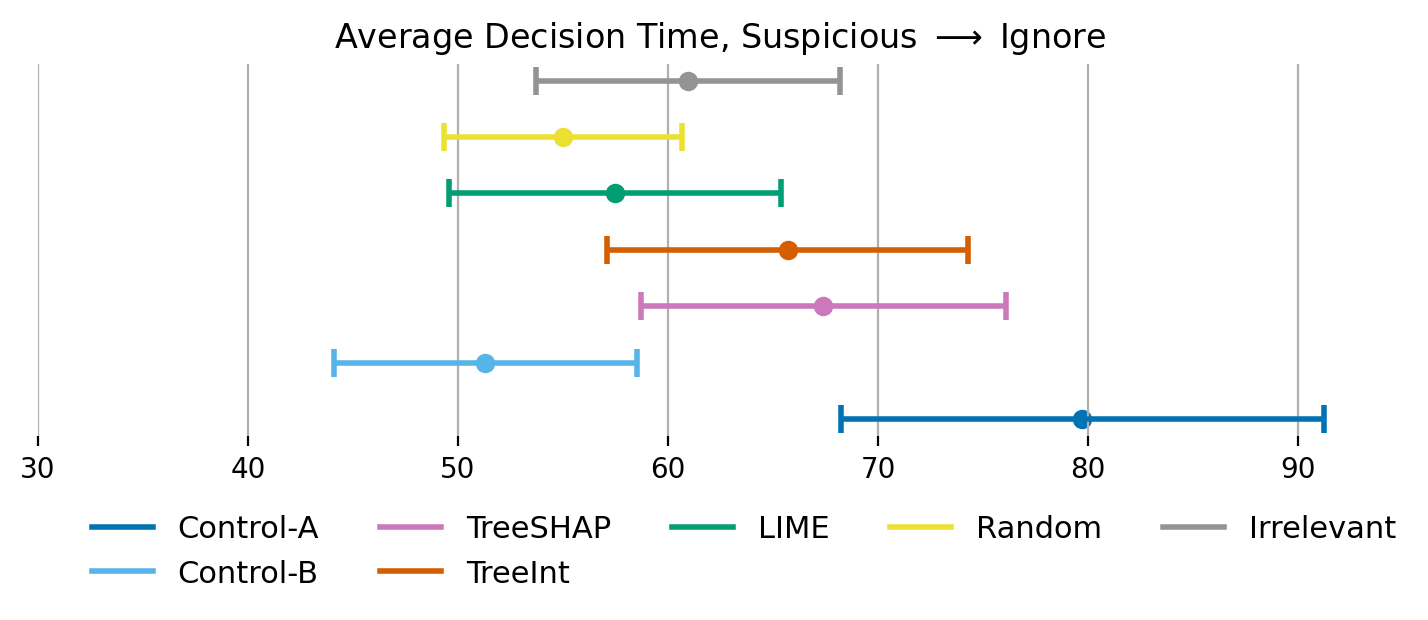

In [25]:
df = dt(all_decisions, params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Correct, w time pen', xlim=[30, 95])

df = dt(all_decisions, params, 'approve', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Approve', xlim=[30, 95])

df = dt(all_decisions, params, 'decline', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Decline', xlim=[30, 95])

df = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Ignore', xlim=[30, 95])


#### Percent Dollar Regret

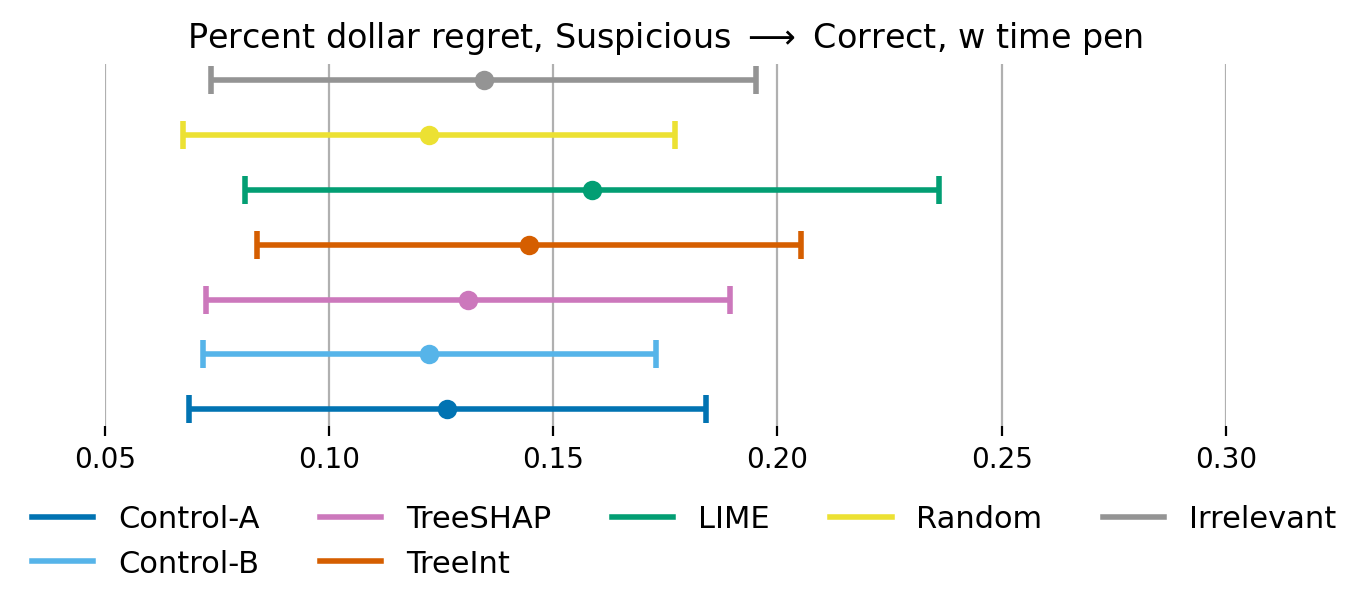

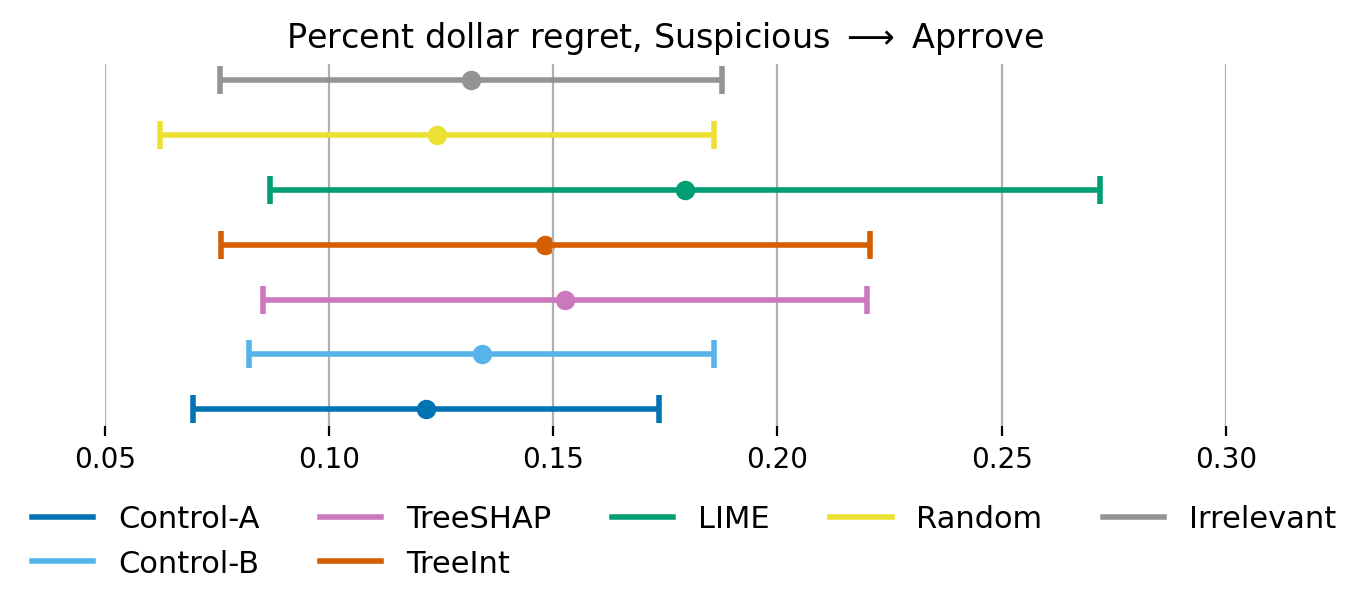

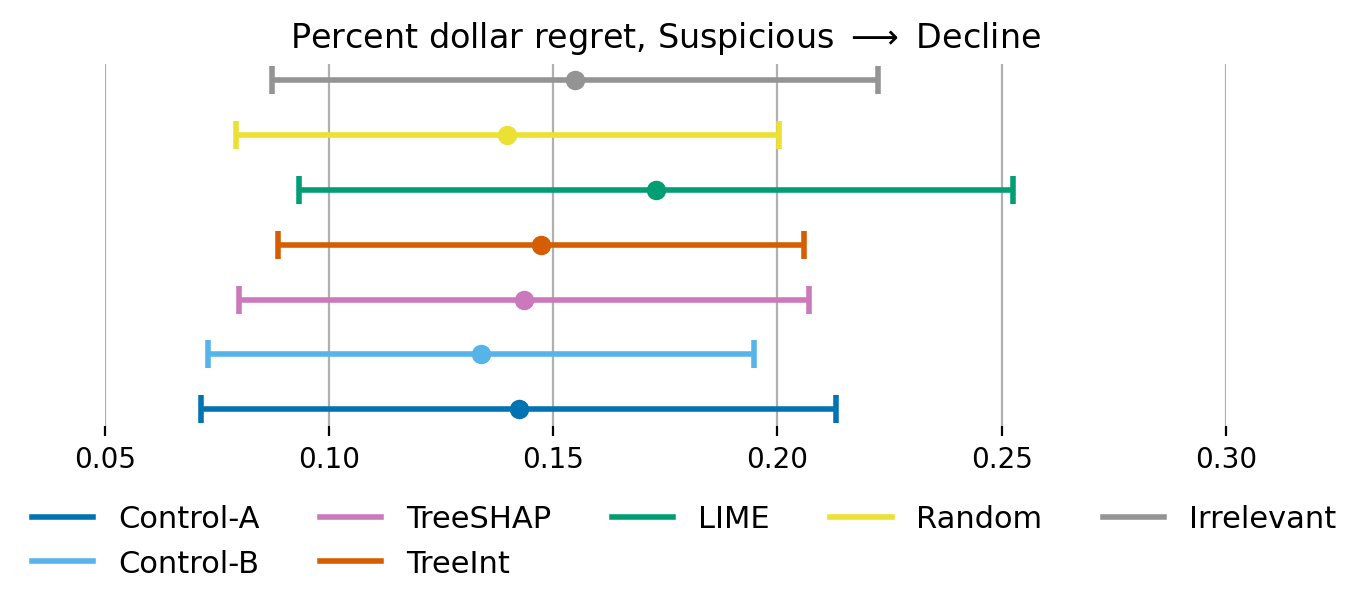

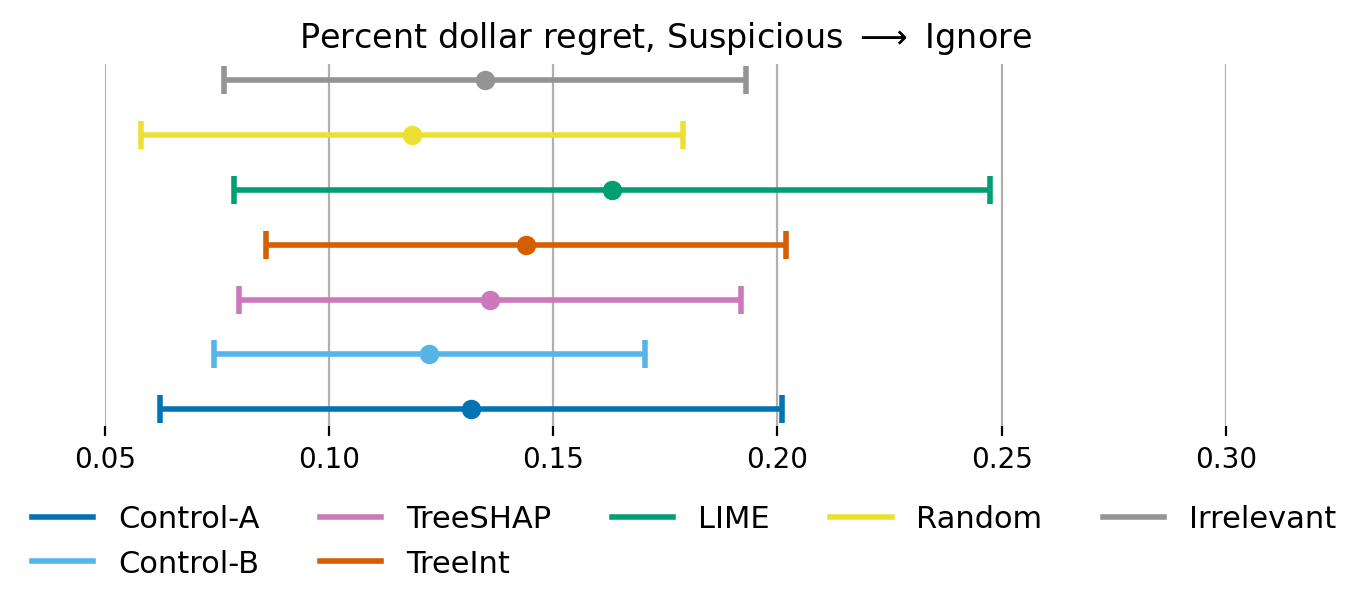

In [15]:
df = pdr(all_decisions, params, 'correct', ['group'])
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Correct, w time pen', 
    legend=True,
    xlim=[0.05, 0.30]
)

df = pdr(all_decisions, params, 'approve', ['group'])
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Aprrove', 
    legend=True,
    xlim=[0.05, 0.30]
)

df = pdr(all_decisions, params, 'decline', ['group'])
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Decline', 
    legend=True,
    xlim=[0.05, 0.30]
)

df = pdr(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Ignore', 
    legend=True,
    xlim=[0.05, 0.30]
)

#### Stat tests

In [21]:
comparisons = [
    ('Control-A', 'Control-B'),
    ('Control-B', 'LIME'),
    ('Control-B', 'TreeInterpreter'),
    ('Control-B', 'TreeSHAP'),
    ('Control-B', 'Random'),
    ('Control-B', 'Irrelevant'),
    ('TreeInterpreter', 'Random'),
    ('TreeSHAP', 'Random'),
    ('LIME', 'Random')
]